# Phonon- Electron thermalization code

In [36]:
using Plots

In [27]:
######### Model/simulation parameters
t𝑝=2 #phonon bandwidth
tₑ=1 #electron bandwidth= = σ
a1=1  #lattice constant
λ𝑐= 1 #phonon-electron coupling
Tₑ=0.75# electron temperature
T𝑝=1.75# phonon temperature
μ = -1  # chemical potential of the electron


#time-simulation parameters
h= 0.08 #the time spacing
Time_max = 50 #the net time
N𝑡= Int64(Time_max/h) #


#phonon volume parameters
sitenum = 4 #gives the no. of sites in the lattice
a2=2*π*(1/(sitenum*a1)) #reciprocal space lattice constant
V_ph = collect(-0.5*sitenum*a2:a2:0.5*a2*(sitenum+1))
#filter!(e->e!=0,V_ph) # not taking k=0 mode currently

5-element Array{Float64,1}:
 -3.141592653589793
 -1.5707963267948966
  0.0
  1.5707963267948966
  3.141592653589793

## Definition of Green's functions

In [28]:
#Phonon definitions

### Disperion relation
function ω𝑝(k)
    return t𝑝*abs(sin(V_ph[k]*a1*0.5))+0.2
end


### Definition of Bare D_0, Dzerobar, and D_zero_K
function D₀ᴿ(k,t1,t2)
    if t1>t2
        return (-(1)*sin(ω𝑝(k)*(t1-t2)*h))/(ω𝑝(k))     # the equal to case shall give 0
    else
        return 0
    end
end


function D̄₀ᴿ(k,t1,t2)
    if t1>=t2                            ### What does D̄ do at equal times? produce 1? What if it rigorously doesn't hold?
        return (-1*cos(ω𝑝(k)*(t1-t2)*h))
    else
        return 0
    end                     #remember this is only true if t1>t2
end


function D₀ᴷ(k,t,t1,Tphonon)
    a= (-im)*(cos(ω𝑝(k)*(t-t1)*h) * coth(ω𝑝(k)*0.5/(Tphonon)) )* (1/ω𝑝(k))
    return a
end

D₀ᴷ(1,2,1,T𝑝)

function D̄₀ᴷ(k,t,t1,Tphonon)
    return im*sin(ω𝑝(k)*(t-t1)*h)*coth(ω𝑝(k)*0.5/(Tphonon))
end



#%%

# Electron Definitions

function ϵₑ(k)
    return tₑ*(1-cos(V_ph[k]*a1))+0.2
end


function G₀ᴿ(k,t1,t2)
    if t1>=t2
        return -im*exp(-im*ϵₑ(k)*(t1-t2)*h)
    else
        return 0
    end
end

    #prints 0 for t1<t2

function G₀ᴷ(k,t1,t2,Telectron,μ)

    return -im*tanh((ϵₑ(k)-μ)/(2*Telectron))*exp(-im*ϵₑ(k)*(t1-t2)*h)
end

G₀ᴷ (generic function with 1 method)

In [29]:
Dᴿmatrix = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

D̄ᴿmatrix = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

Dᴷmatrix = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

D̄ᴷmatrix = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

Gᴿmatrix = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

Gᴷmatrix = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

Σ𝑝ᴿ= Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

Σ𝑝ᴷ = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

Σₑᴿ = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

Σₑᴷ = Array{Array{ComplexF64,2},1}(undef,length(V_ph)+2)

matinit = function ()
    for i=1:length(V_ph)+2
        Dᴿmatrix[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
        D̄ᴿmatrix[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
        Dᴷmatrix[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
        D̄ᴷmatrix[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
        Gᴿmatrix[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
        Gᴷmatrix[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
        Σ𝑝ᴿ[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
        Σ𝑝ᴷ[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
        Σₑᴿ[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
        Σₑᴷ[i] = Array{ComplexF64,2}(undef,N𝑡+5,N𝑡+5)
    end
end

#21 (generic function with 1 method)

## Convolution Function definitions

In [46]:
function F(k,t₁,t₂)
    if t₁>t₂
#         sum=0
#         for i=t2:t1
#             sum=sum+ Σ𝑝ᴿ[k][t₁,i]*Dᴿmatrix[k][i,t₂]*h
#         end
        
        return sum(t->Σ𝑝ᴿ[k][t₁,t]*Dᴿmatrix[k][t,t₂]*h, collect(t₂:t₁))

    elseif t₁==t₂
        return 0
    else
        return "You're convoluting in the opposite direction. Possible error at RR conv"
    end
end



function RK(k,t1,t2) #∫₀ᵗ Σ𝑝ᴿ⋅Dᴷ
    if t1>1
        sum=0
        for i=1:t1
            sum=sum+Σ𝑝ᴿ[k][t1,i]*Dᴷmatrix[k][i,t2]*h
        end
        return sum
#        return sum(t->Σ𝑝ᴿ[k][t1,t]*Dᴷmatrix[k][t,t2]*h, collect(1:t1))
    else
        return 0
    end
end


function KA(k,t1,t2) #∫₀⋅Dᴿ
    if t2>1
        sum=0
        for i=1:t2
            sum=sum+Σ𝑝ᴷ[k][t1,i]*Dᴿmatrix[k][t2,i] * h
        end
        return sum
#        return sum(t->Σ𝑝ᴷ[k][t1,t]*Dᴿmatrix[k][t2,t] * h, collect(1:t2)) ## Dᴬ is just transpose of Dᴿ
    else
        return 0
    end
end


###### Equivalent definitions of convolutions for electrons ###########
function ϵₑ(k)
    return tₑ*(1-cos(V_ph[k]*a1))           #(1-cos(V_ph[k]*a1))
end


function G₀ᴿ(k,t1,t2)
    if t1>=t2
        return -im*exp(-im*ϵₑ(k)*(t1-t2)*h)
    else
        return 0
    end
end

    #prints 0 for t1<t2

function G₀ᴷ(k,t1,t2,Telectron,μ)

    return -im*tanh((ϵₑ(k)-μ)/(2*Telectron))*exp(-im*ϵₑ(k)*(t1-t2)*h)
end


## Convolution function definition

function Fₑ(k,t₁,t₂)
    if t₁>t₂
        return sum(t->Σₑᴿ[k][t₁,t]*Gᴿmatrix[k][t,t₂]*h, collect(t₂:t₁))
    elseif t₁==t₂
        return 0
    else
        return "You're convoluting in the opposite direction. Possible error at RR/electron conv"
    end
end

function RKₑ(k,t1,t2) #∫₀ᵗ Σₑᴿ⋅Dᴷ
    if t1>1
        sum=0
        for i=1:t1
            sum = sum+Σₑᴿ[k][t1,i]*Gᴷmatrix[k][i,t2]*h
        end
        #result1 = sum(t->Σₑᴿ[t1,t]*Gᴷmatrix[k][t,t2]*h, collect(1:t1))
        return sum
    else
        return 0
    end
end

function KAₑ(k,t1,t2) #∫₀⋅Dᴿ
    if t2>1
        return sum( t->Σₑᴷ[k][t1,t]* conj(Gᴿmatrix[k][t2,t]) * h, collect(1:t2) )
    else
        return 0
    end
end


#         sum=0
#         for i=1:t2
#             sum=sum+ Σₑᴷ[k][t1,i]* conj(Gᴿmatrix[k][t2,i]) * h
#         end
        #result1 = sum( t->Σₑᴷ[t1,t]* conj(Gᴿmatrix[k][t2,t]) * h, collect(1:t2) )


function sumBZ1d(k,p) # returns the index of element in the BZ array that reflects the physical sum of two input indices, taking the periodic behaviour into account
    if V_ph[k]*V_ph[p] ==(π/a1)^2
        return p

    elseif -1*π/a1<=V_ph[k]+V_ph[p]<=π/a1
        res = V_ph[k]+V_ph[p]
        return findmin(abs.(V_ph.-res))[2]

    elseif V_ph[k]+V_ph[p]>π/a1
        res = V_ph[k]+V_ph[p]-2*π/a1
        return findmin(abs.(V_ph.-res))[2]

    else V_ph[k]+V_ph[p]<-1*π/a1
        res = V_ph[k]+V_ph[p]+2*π/a1
        return findmin(abs.(V_ph.-res))[2]
    end
end


function negative(k) # returns array index of -k vector
    middle = (length(V_ph)+1)*0.5
    l=length(V_ph)
    return Int((k<middle)*(l-k+1) + (k==middle)*middle+ (k>middle)*(middle-(k-middle)))
end

negative (generic function with 1 method)

In [47]:
KA(2,2,3)

0.0 + 0.0im

In [32]:
boxinitindex=2
boxinit=function()

    for k =1:length(V_ph)
        for i=1:N𝑡
            Dᴿmatrix[k][i,i]=0 #exactly 0
            D̄ᴿmatrix[k][i,i]=-1 #exactly 1
            Gᴿmatrix[k][i,i] = -im #exactly true           ## Gr(t,t)≂̸0
        end
    end
    
    ######## Box Initialization ############

    #GF Initialization

    for k=1:length(V_ph)
        for i=1:boxinitindex
            for j=1:boxinitindex
                Dᴿmatrix[k][i,j] = D₀ᴿ(k,i,j)
                D̄ᴿmatrix[k][i,j] = D̄₀ᴿ(k,i,j)
                Dᴷmatrix[k][i,j] = D₀ᴷ(k,i,j,T𝑝)
                D̄ᴷmatrix[k][i,j] = D̄₀ᴷ(k,i,j,T𝑝)
                Gᴿmatrix[k][i,j] = G₀ᴿ(k,i,j)
                Gᴷmatrix[k][i,j] =  G₀ᴷ(k,i,j,Tₑ,μ)

            end
        end
    end
end

#31 (generic function with 1 method)

In [33]:
matinit()
boxinit()

In [34]:
#Actual for loop
testrange=100
for i=boxinitindex+1:testrange       ### The diagonal value #should probably start from 2

    #Update DR
    for k=1:length(V_ph)
        for j=1:i

            if j<i
                D̄ᴿmatrix[k][i,j] = ω𝑝(k)^2 * D₀ᴿ(k,i,i-1) * Dᴿmatrix[k][i-1,j] - D̄₀ᴿ(k,i,i-1) * D̄ᴿmatrix[k][i-1,j] + (h/2)*( D̄₀ᴿ(k,i,i)* F(k,i,j) + D̄₀ᴿ(k,i,i-1) * F(k,i-1,j) )
            end
            Dᴿmatrix[k][i+1,j] = D̄₀ᴿ(k,i+1,i) * Dᴿmatrix[k][i,j] + D₀ᴿ(k,i+1,i) * D̄ᴿmatrix[k][i,j] + (h/2)*D₀ᴿ(k,i+1,i)*F(k,i,j)
        end
    end

     #Update DK
     for k = 1:length(V_ph)
         for j=1:i
             D̄ᴷmatrix[k][i,j] = ω𝑝(k)^2 * D₀ᴿ(k,i,i-1) * Dᴷmatrix[k][i-1,j] - D̄₀ᴿ(k,i,i-1) * D̄ᴷmatrix[k][i-1,j] + (h/2)*(  D̄₀ᴿ(k,i,i)* RK(k,i,j) + D̄₀ᴿ(k,i,i-1)* RK(k,i-1,j) + D̄₀ᴿ(k,i,i)* KA(k,i,j) + D̄₀ᴿ(k,i,i-1)* KA(k,i-1,j) )
             Dᴷmatrix[k][i+1,j] = D̄₀ᴿ(k,i+1,i) * Dᴷmatrix[k][i,j] + D₀ᴿ(k,i+1,i) * D̄ᴷmatrix[k][i,j] + (h/2)*( D₀ᴿ(k,i+1,i)* RK(k,i,j) + D₀ᴿ(k,i+1,i)* KA(k,i,j) )
             Dᴷmatrix[k][j,i+1] = -conj(Dᴷmatrix[k][i+1,j])
             D̄ᴷmatrix[k][j,i] = +conj(D̄ᴷmatrix[k][i,j])#what abt i,i entry? If Dk is imaginary, then it will just flip sign here.....? This term is to take care of that...Not sure
         end
     end

    # Update GR, GK
    for k = 1 : length(V_ph)
        for j=1:i
            Gᴿmatrix[k][i+1,j] = im*G₀ᴿ(k,i+1,i)*Gᴿmatrix[k][i,j] + (h/2)* G₀ᴿ(k,i+1,i)*(Fₑ(k,i,j))
            Gᴷmatrix[k][i+1,j] = im*G₀ᴿ(k,i+1,i)*Gᴷmatrix[k][i,j]+ (h/2)*G₀ᴿ(k,i+1,i)* (RKₑ(k,i,j) + KAₑ(k,i,j))
            Gᴷmatrix[k][j,i+1] = - conj(Gᴷmatrix[k][i+1,j]) # iGᴷ is hermitian  ⟹ iGᴷ(1,2) = conj((iGᴷ(2,1)) ⟹ Gᴷ(1,2) = - conj(Gᴷ(2,1))
        end
    end

    
    Gᴿmatrix[k][i+1,j] = im*G₀ᴿ(k,i+1,i)*Gᴿmatrix[k][i,j] + (h/2)* G₀ᴿ(k,i+1,i)*(Fₑ(k,i,j))+ (h/2)* G₀ᴿ(k,i+1,i)*(Fₑ(k,i,j))+ (h/2)* G₀ᴿ(k,i+1,i+1)*Fₑ(k,i+1,j)
        end
    end


Gᴷmatrix[k][i+1,j] = im*G₀ᴿ(k,i+1,i)*Gᴷmatrix[k][i,j]+ (h/2) * G₀ᴿ(k,i+1,i) * ( RKₑ(k,i,j) + KAₑ(k,i,j) )+ (h/2) * G₀ᴿ(k,i+1,i+1) * ( RKₑ(k,i+1,j) + KAₑ(k,i+1,j) )   
            Gᴷmatrix[k][j,i+1] = - conj(Gᴷmatrix[k][i+1,j]) # iGᴷ is hermitian  ⟹ iGᴷ(1,2) = conj((iGᴷ(2,1)) ⟹ Gᴷ(1,2) = - conj(Gᴷ(2,1))
        end
    end
    
    
    
    

    # Extract Phonon self energy Σ𝑝ᴷ,Σ𝑝ᴿ in the n+1,n+1 block (use in Dr calculation in next loop)
    # Σ𝑝ᴿ update
    for j=1:i
        for k=1:length(V_ph)
            sum=0
            for p=1:length(V_ph)
                sum = sum -im*(λ𝑐^2/2)*(Gᴿmatrix[sumBZ1d(k,p)][i+1,j]*Gᴷmatrix[p][j,i+1] + Gᴷmatrix[sumBZ1d(k,p)][i+1,j]* conj(Gᴿmatrix[p][i+1,j]) )
            end
            Σ𝑝ᴿ[k][i+1,j]=sum
            sum=nothing
        end
    end

    # Σ𝑝ᴷ Update
    for j=1:i
        for k=1:length(V_ph)
            sum1=0
            sum2=0
            for p=1:length(V_ph)
                ### Code for lower edge
                sum1 = sum1 - im*(λ𝑐^2/2)*( Gᴿmatrix[sumBZ1d(k,p)][i+1,j]*conj(Gᴿmatrix[p][i+1,j]) - Gᴷmatrix[sumBZ1d(k,p)][i+1,j]*conj(Gᴷmatrix[p][i+1,j])  )

                ### Code for upper edge
                sum2 = sum2- im*(λ𝑐^2/2)*( conj(Gᴿmatrix[sumBZ1d(k,p)][i+1,j])*Gᴿmatrix[p][i+1,j] - Gᴷmatrix[sumBZ1d(k,p)][j,i+1]*conj(Gᴷmatrix[p][j,i+1]) )
            end
            Σ𝑝ᴷ[k][i+1,j]= sum1
            Σ𝑝ᴷ[k][j,i+1]= sum2
            sum1=nothing
            sum2=nothing
        end
    end

    #Now extract self energies Σₑᴿ,Σₑᴷ in the n+1,n+1 block (shall be used for calculation of GR in n+2,n+2 loop i.e. next big loop's GR,GK update since you're dropping the self consistent term)

    ## Σₑᴿ Update
    for j=1:i
        for k=1:length(V_ph)
            sum=0
            for p=1:length(V_ph)
                sum = sum + im*( λ𝑐^2/2 )*( Gᴿmatrix[sumBZ1d(k,p)][i+1,j] * Dᴷmatrix[negative(p)][i+1,j] + Gᴷmatrix[sumBZ1d(k,p)][i+1,j] * Dᴿmatrix[negative(p)][i+1,j] )
            end
            Σₑᴿ[k][i+1,j]= sum
            sum=nothing
        end
    end

    ## Σₑᴷ Update
    for j=1:i
        for k=1:length(V_ph)
            sum1=0
            sum2=0
            for p=1:length(V_ph)
                ## code for upper edges
                sum1 = sum1+im*(λ𝑐^2/2)*( Gᴿmatrix[sumBZ1d(k,p)][i+1,j] * Dᴿmatrix[negative(p)][i+1,j] + Gᴷmatrix[sumBZ1d(k,p)][i+1,j] * Dᴷmatrix[negative(p)][i+1,j]  )

                ## code for lower edges
                sum2 = sum2+ im*(λ𝑐^2/2)*( conj( Gᴿmatrix[sumBZ1d(k,p)][i+1,j] )* Dᴿmatrix[p][i+1,j] - conj( Gᴷmatrix[sumBZ1d(k,p)][i+1,j] ) * Dᴷmatrix[p][i+1,j] )
            end
            Σₑᴷ[k][i+1,j]=sum1
            Σₑᴷ[k][j,i+1]=sum2
            sum1=nothing
            sum2=nothing
        end
    end

    ############## Diagonal terms update #############


    #Update GK(t+ϵ,t+ϵ) i.e GK(i+1,i+1) here  - needs Σₑᴿ on the i+1 block edges  i.e.
    for k=1:length(V_ph)
        Gᴷmatrix[k][i+1,i+1] = im*G₀ᴿ(k,i+1,i)*Gᴷmatrix[k][i,i+1]+ (h/2)*G₀ᴿ(k,i+1,i)* (RKₑ(k,i,i+1) + KAₑ(k,i,i+1))
    end
    #initialie Gr(i+1,i+1) = -im from before i.e. outside this loop
    
    
    
    
    #### Here there should be regeneration code should be present to allow for production of new green's functions###
                ### stuff should include -  a root calculating module - employs number and avg energy conservation
    
    #### now use this to compute Σ𝑝ᴷ,Σ𝑝ᴿ for the next time step i.e. in this whole edge

    #updating Σ𝑝ᴿ[i+1,i+1],Σ𝑝ᴷ[i+1,i+1]
    for k=1:length(V_ph)
        sum=0
        for p=1:length(V_ph)
            sum = sum -im*(λ𝑐^2/2)*( Gᴿmatrix[sumBZ1d(k,p)][i+1,i+1]*Gᴷmatrix[p][i+1,i+1] + Gᴷmatrix[sumBZ1d(k,p)][i+1,i+1]* conj(Gᴿmatrix[p][i+1,i+1]) )
        end
        Σ𝑝ᴿ[k][i+1,i+1]=sum
        sum=nothing
    end
    #- this will be used to update the DR[i+1,i+1]

    #updating Σ𝑝ᴷ(i+1,i+1)
    for k=1:length(V_ph)
        sum=0
        for p=1:length(V_ph)
            sum = sum - im*(λ𝑐^2/2)*( Gᴿmatrix[sumBZ1d(k,p)][i+1,i+1]*conj(Gᴿmatrix[p][i+1,i+1]) - Gᴷmatrix[sumBZ1d(k,p)][i+1,i+1]*conj(Gᴷmatrix[p][i+1,i+1])  )
        end
        Σ𝑝ᴷ[k][i+1,i+1] = sum
        sum=nothing
    end


    #Update DK(t+ϵ,t+ϵ) here, D̄(i,i) block is calculated already
    for k=1:length(V_ph)
        D̄ᴷmatrix[k][i+1,i] = ω𝑝(k)^2 * D₀ᴿ(k,i+1,i) * Dᴷmatrix[k][i,i] - D̄₀ᴿ(k,i+1,i) * D̄ᴷmatrix[k][i,i] + (h/2)*(  D̄₀ᴿ(k,i+1,i+1)* RK(k,i+1,i) + D̄₀ᴿ(k,i+1,i)* RK(k,i,i) + D̄₀ᴿ(k,i+1,i+1)* KA(k,i+1,i) + D̄₀ᴿ(k,i+1,i)* KA(k,i,i) )
        D̄ᴷmatrix[k][i,i+1] = conj( D̄ᴷmatrix[k][i+1,i] )
        Dᴷmatrix[k][i+1,i+1] = D̄₀ᴿ(k,i+1,i) * Dᴷmatrix[k][i,i+1] + D₀ᴿ(k,i+1,i) * D̄ᴷmatrix[k][i,i+1] + (h/2)*( D₀ᴿ(k,i+1,i)* RK(k,i,i+1) + D₀ᴿ(k,i+1,i)* KA(k,i,i+1) )
    end

    #updating sigmElR, sigmaElK here (given that now you've all Gfuncs at the i+1,i+1)
    for k=1:length(V_ph)
        sum=0
        for p=1:length(V_ph)
            sum = sum + im*( λ𝑐^2/2 )*( Gᴿmatrix[sumBZ1d(k,p)][i+1,i+1] * Dᴷmatrix[negative(p)][i+1,i+1] + Gᴷmatrix[sumBZ1d(k,p)][i+1,i+1] * Dᴿmatrix[negative(p)][i+1,i+1] )
        end
        Σₑᴿ[k][i+1,i+1]= sum
        sum=nothing
    end

    for k=1:length(V_ph)
        sum=0
        for p=1:length(V_ph)
            sum = sum+im*(λ𝑐^2/2)*( 0 + Gᴷmatrix[sumBZ1d(k,p)][i+1,i+1] * Dᴷmatrix[negative(p)][i+1,i+1]  )
        end
        Σₑᴷ[k][i+1,i+1]=sum
        sum=nothing
    end

end

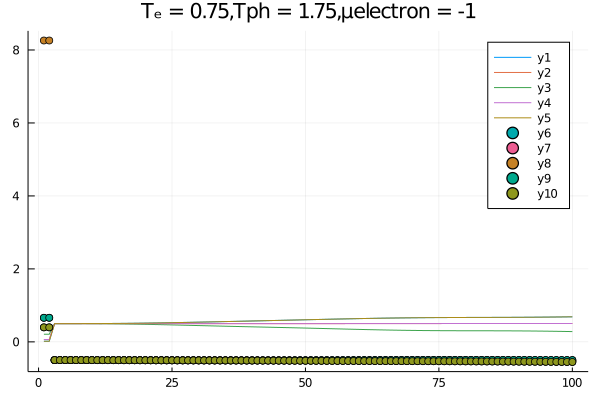

In [45]:
b2=[]
a2=[]
boxinitindex
testrange
list=[1 10]
for m=1:length(V_ph)
    b = Array{ComplexF64}(undef,testrange)
    a=  Array{ComplexF64}(undef,testrange)
    for i=1:testrange
        #b[i] = Gᴿmatrix[m][i,1]
        b[i] = (imag(Gᴷmatrix[m][i,i])+1)*0.5
        #b[i] = Gᴷmatrix[m][i,i]
        a[i] = (ω𝑝(m)*im*Dᴷmatrix[m][i,i]-1)*0.5
    end
    push!(b2,b)
    push!(a2,a)
end

b2
ser = collect(1:testrange)
plot(ser,real.(b2),title = "Tₑ = $(Tₑ),Tph = $(1.75),μelectron = $(μ)",lw=1) 
#scatter(ser,real.(a2),lw=0.2)

In [52]:
disp_electron= []
for m=1:length(V_ph)
    push!(disp_electron,ϵₑ(m))
end

x=collect(-π/a1:a2:π/a1)

scatter(x,disp_electron,label="system")
#plot!(x, 2*-tB*cos.(x.*a1),title = "Dispersion of system & bath",label="Bath")
#plot!(collect(-π/a1:1e-2:π/a1),μ.+collect(-π/a1:1e-2:π/a1).*0,label = "μ_electron = $(μ)")
#plot!(collect(-π/a1:1e-2:π/a1),μbath.+collect(-π/a1:1e-2:π/a1).*0,label = "μ_bath = $(μbath)")

LoadError: [91mMethodError: no method matching zero(::Type{Any})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  zero(::Type{Union{Missing, T}}) where T at missing.jl:104[39m
[91m[0m  zero([91m::Type{Missing}[39m) at missing.jl:103[39m
[91m[0m  zero([91m::Type{Dates.DateTime}[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/Dates/src/types.jl:404[39m
[91m[0m  ...[39m